In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import scipy
from scipy.stats import norm

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual


In [2]:
import sys

sys.path.append('/home/ewout/enem_atp/')
from util import load_sample, load_acertos,provas,score_inep,load_padr,item_info_inep, params_inep, scalecalparams, notas_to_enem_scale
%load_ext autoreload
%autoreload 2

# Como funciona a TRI
A teoria de resposta ao item (TRI) é uma metodologia para calcular notas a partir de padrões de respostas a "itens" (questões). Ao invés de simplesmente somar o número de acertos, o cálculo da nota pela TRI usa todo o padrão de resposta do candidato, levando em conta as características das questões (dificuldade, poder de "discriminação"). Assim, como veremos abaixo, candidatos com o mesmo número de acertos podem ter notas completamente diferentes, dependendo de *quais* questões acertaram, não somente o número delas. 

Por um lado, a metodologia TRI tem vantagens, o principal delas sendo o fato que as notas calculadas pela TRI podem ser comparadas entre edições da prova, por exemplo em anos diferentes. É por esta razão que avaliações educacionais como o SAEB, o sistema que monitora o desempenho de alunos do ensino básico, usa TRI. Mas por outro lado, há a grande desvantagem que o cálculo da nota pela TRI é um processo opaco para o candidato. Como explicar a alguém com 10 acertos que ele recebeu, digamos, 400 pontos e um outro candidato recebeu 520 pontos?

Com um pouco de esforço, é possíve abrir a caixa opaca da TRI. É possível reproduzir as notas do ENEM usando as padrões de resposta dos candidatos. Vamos começar mostrando os dados que temoss, carregando uma amostra de alguns dos milhões de candidatos que fizeram a prova de 2023.

```{admonition} Microdados
Para este projeto baixamos [os microdados do ENEM](https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados) disponibilizados pelo INEP. Para ver o nosso *pipeline* de processamento de dados e as funções que usamos abaixo, veja o nosso repositório de código: https://github.com/atp/enem
```

In [3]:
load_sample(2023,5)

,NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
4294,210060244946,2023,4,M,1,3,1,1,2,1,...,B,A,B,D,B,A,D,A,B,B
16457,210060602594,2023,3,M,1,1,1,2,0,3,...,B,A,B,E,B,B,D,B,E,B
10345,210060080161,2023,19,M,2,3,1,1,0,1,...,A,A,B,C,B,A,C,A,C,B
10693,210058076047,2023,4,M,1,3,1,2,0,2,...,A,A,A,B,A,A,B,A,A,A
4594,210060635922,2023,2,M,1,3,1,1,1,1,...,A,A,A,A,A,A,C,A,A,A


Vemos que para cada candidato há informaçoes contextuais (autoreportado, na hora de fazer a inscrição do ENEM) sobre idade, sexo, cor/raça e outros variáveis. Nesta base também constam os padrões de resposta e a nota ENEM determinado pelo INEP. Transformamos estes dados numa outra tabela para facilitar as análises que vamos fazer:

In [4]:
load_acertos(2023,'CN',5)

,40724,60332,126604,117631,43890,85436,26042,83558,64023,87989,...,111665,84422,83378,117887,66330,48492,63155,acertos,caderno,nota_inep
candidato,,,,,,,,,,,,,,,,,,,,,
210060105242,1,0,1,1,1,1,1,0,0,0,...,0,0,1,0,0,0,0,15,1224,532.8
210060522409,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,6,1221,329.2
210061890057,0,0,0,1,0,0,0,1,0,1,...,0,0,1,0,0,1,1,11,1224,441.8
210059579028,0,0,0,0,0,1,0,0,1,0,...,0,0,1,1,0,0,0,9,1221,419.2
210058117429,0,0,1,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,5,1221,427.5


Com os dados neste formato, podemos reproduzir as notas dadas pela INEP. Vamos transformar os 45 acertos e erros, ou "0"s e "1"s dos candidatos, em notas calculadas pelo TRI, usando os parâmetros das questões (itens, no jargão das especialistas em avaliação) fornecido pelo INEP. O resultado vai ser uma nota na "escala ENEM", que varia na prática entre 300 e 800 ou 900.

```{admonition} Interpretação da escala ENEM
Uma das interpretações equivocadas da escala ENEM mais comuns é equiparar as notas, ainda implicitamente, a uma nota escolar do 0 até 10. Porém, não é correto interpretar 600 ou 700 na escala ENEM como sendo "mais ou menos satisfatória", como faríamos com notas escolares. Ao vez disso, a interpretação correta é que 500 é a média da população referência (alunos no final do ensino médio em 2009) e 100 pontos na escala ENEM corresponde a um desvio padrão da população de referência. Assim, uma nota acima de 700 na escala ENEM seria atingido por somente 2,5% da população de referência. 
```

## A nota TRI é bem diferente do que o número de acertos
Antes de mostrar como notas são calculadas na escala ENEM, mostramos o que todo mundo que já fez o ENEM sabe: dois candidatos com o mesmo número de acertos podem ter notas ENEM bem diferentes. Não é somente o número de acertos que conta, é também o padrão de respostas que é levado em conta:

<Axes: xlabel='acertos', ylabel='nota_inep'>

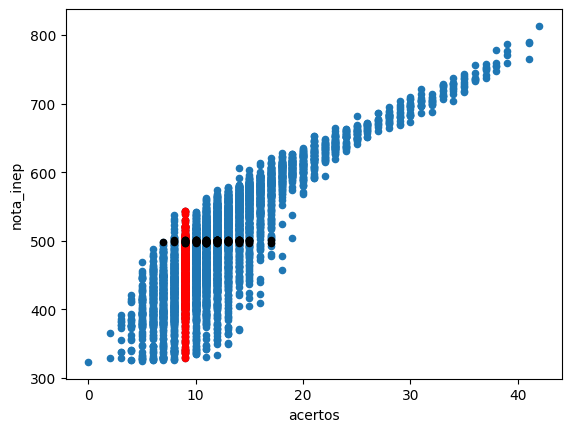

In [5]:
ano = 2023
area = 'CN'
df = load_acertos(ano,area,5000)
ax = df.plot(kind='scatter',x='acertos',y='nota_inep')
df.query("acertos == 9").plot(kind='scatter',x='acertos',y='nota_inep', color='r',ax=ax)
df.query("nota_inep > 497 & nota_inep < 502").plot(kind='scatter',x='acertos',y='nota_inep', color='k',ax=ax)

Vemos que para pessoas com 9 acertos a nota ENEM pode variar de 330 até 530, dependendo quais questões acertaram. E, para quem tirou uma nota ENEM de 500, o número de acertos pode ter sido entre 9 e 16.

## O "peso" da questão não é sua dificuldade

O que explica esta diferença é o padrão de respostas dos candidatos. De uma forma geral, quem acerta de forma mais consistente ganha uma nota maior. Mas, contrário ao senso comum, não é verdade que questões mais difíceis "pesam mais" e levam a uma nota maior. Talvez surpreendentemente, dado um certo número de acertos, é melhor acertar itens fáceis do que acertar itens difícil. Podemos mostrar isso com candidatos reais.

O INEP fornece os parâmetros dos itens, as características das questões determinadas durante o processo de testagem. O parâmetro $a$ representa a "discriminação" do item, $b$ é a dificuldade e $c$ a probabilidade de acerto por acaso. Mais abaixo explicamaremos melhor como interpretar estes parâmetros. Agora vamos mostrar que o parâmetro `b` *não* deve ser interpretado como o "peso" da questão. 

In [6]:
prova = 1222
params = params_inep(prova=prova)
params[:5]

,a_inep,b_inep,c_inep,u
CO_ITEM,,,,
64023,1.81427,1.41990,0.25187,1
97149,0.99037,1.55817,0.20321,1
84041,3.68114,1.27129,0.10000,1
66259,2.34079,1.00185,0.23885,1
117866,2.33748,1.77344,0.10811,1


Com algumas manobras, podemos mostrar a diferença entre as padrões de resposta de dois candidatos com o mesmo número de acertos. Observe que a nota alta é obtida para quem acerto as questões mais fáceis. O padrão com acertos em itens difíceis mas erros em itens fáceis é pouco provável e o algoritmo TRI associa uma nota baixa. 

In [7]:
itens_a = pd.qcut(params['a_inep'],3,labels=['Baixa','Média','Alta'])
itens_b = pd.qcut(params['b_inep'],3,labels=['Baixa','Média','Alta'])
itens = pd.concat([itens_a,itens_b],axis=1)
itens.columns = ['discriminação','dificuldade']

def compare_padr(nacertos=9):
    padrmin = df.loc[df.query("acertos == @nacertos")['nota_inep'].idxmin()]
    padrmax = df.loc[df.query("acertos == @nacertos")['nota_inep'].idxmax()]
    notamin,notamax = padrmin['nota_inep'], padrmax['nota_inep']
    padrmin = padrmin[:-3]; padrmax = padrmax[:-3]
    padrmin.index = padrmin.index.astype(str);padrmax.index = padrmax.index.astype(str)
    result = params.join(itens).join(padrmin).join(padrmax)
    result.columns = ['a','b','c','u','discriminação','dificuldade','nota_baixa','nota_alta']
    result = result.sort_values(['b'],ascending=True).query("nota_baixa == 1 or nota_alta == 1")
    result.columns = ['a','b','c','u','discriminação','dificuldade',f'nota = {notamin}',f'nota = {notamax}']
    return result

iw = widgets.IntText(
    value=9,
    description='Acertos:',
)
interact(compare_padr, nacertos=iw);

interactive(children=(IntText(value=9, description='Acertos:'), Output()), _dom_classes=('widget-interact',))

Podemos também comparar dois candidatos com notas parecidas do ENEM. Vemos na figura acima que candidatos com uma nota de 500 podem ter acertado entre 6 e 15 itens. Qual é a diferença entre os padrões de resposta deste dois candidatos?

Veja abaixo como o padrão de resposta é diferente para dois candidatos com essencialmente a mesma nota ENEM. O primeiro, com poucos acertos, acertou quase todas as questões fáceis. O segundo também acertou uma fração das questões fáceis, mas errou alguns. Apesar de ter acertadas itens difíceis, não adiantou. Acertar uma questão difícil sem acertar as fáceis não leva a notas maiores no TRI. 

In [8]:
nota1, nota2 = 499,501
dfn = df.query("nota_inep <= @nota2 and nota_inep > @nota1")
padrmin = dfn.loc[dfn['acertos'].idxmin()]
padrmax = dfn.loc[dfn['acertos'].idxmax()]
notamin,notamax = padrmin['nota_inep'], padrmax['nota_inep']
acertosmin,acertosmax = padrmin['acertos'], padrmax['acertos']
padrmin = padrmin[:-3]; padrmax = padrmax[:-3]
padrmin.index = padrmin.index.astype(str);padrmax.index = padrmax.index.astype(str)
result = params.join(itens).join(padrmin).join(padrmax)
result.columns = ['a','b','c','u','discriminação','dificuldade','nota_baixa','nota_alta']
result = result.sort_values(['b'],ascending=True).query("nota_baixa == 1 or nota_alta == 1")
result.columns = ['a','b','c','u','discriminação','dificuldade',f'acertos: {acertosmin}, nota: {notamin}',f'acertos: {acertosmax}, nota = {notamax}']
result = result.drop(columns=['a','b','c','u'])
result

,discriminação,dificuldade,"acertos: 8.0, nota: 499.7","acertos: 17.0, nota = 500.4"
CO_ITEM,,,,
83378,Baixa,Baixa,1.0,0.0
40724,Baixa,Baixa,1.0,1.0
126604,Alta,Baixa,1.0,0.0
117631,Baixa,Baixa,1.0,1.0
141723,Média,Baixa,1.0,1.0
111665,Alta,Baixa,0.0,1.0
87989,Média,Baixa,0.0,1.0
47317,Média,Baixa,0.0,1.0
63155,Alta,Média,0.0,1.0


## O modelo TRI determina a probabilidade dos padrões de resposta
A teoria de resposta ao item faz uma modelagem probabilística para as respostas de um candidato às questões da prova. Vamos chamar a habilidade (presuposto uma quantidade unidimensional nos modelos simples) $\theta$ e os padrões de resposta $x_i = 0$ (errou) ou $1$ (acertou) para $i=1\ldots 45$. Então o model TRI postula que um candidato com habilidade $\theta$ tem uma certa probabilidade $P_i(x_i = 1|\theta;a_i,b_i,c_i)$ que o candidato acertar a questão $i$. É esta "habilidade" $\theta$ que vai virar a nota do ENEM.

Vamos ver exemplos concretos desta função $P_i(x_i = 1|\theta;a_i,b_i,c_i)$, usando os parâmetros das primeiras cinco questões da prova que estamos ananlisando:

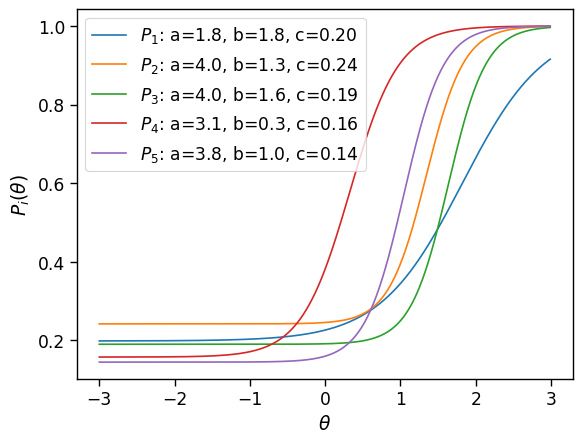

In [9]:
sns.set_context('paper',font_scale=1.4)

params = params_inep(ano,area)[:5]
theta = np.arange(-3,3,0.01)
def P(theta,a=1,b=0,c=0):
    return c + (1-c)*1/(1+np.exp(a*(b-theta)))
i = 0
for item,value in params.iterrows():
    i += 1
    a,b,c = value['a_inep'],value['b_inep'],value['c_inep']
    sns.lineplot(x=theta,y=P(theta,a,b,c), label=f"$P_{i}$: a={a:.1f}, b={b:.1f}, c={c:.2f}")
ax = plt.gca()
ax.set_xlabel(r"$\theta$");ax.set_ylabel(r"$P_i(\theta)$");

Vemos que a probabilidade de acertar depende da habilidade do candidato e das características das questões (parametrizado acima com três parâmetros, mas pode haver outros modelos para as características das questões). Qualquer modelo razoável vai dar uma probabilidade maior de acerto para habilidades $\theta$ maiores. Da mesma forma, a probabilidade de acerto deve diminuir para questões mais difíceis (para uma determinada habilidade fixa). Grande parte do problema técnica da TRI é estimar, baseado em muitas padrões de resposta a provas como estas que vimos acima, as características das questões. Por agora vamos supor que esta calibração das características das questões foi feito e que conhecemos os parâmetros das questões e portanto as funções $P_i$. Agora vamos se perguntar: dado uma certa habilidade, quais serão as padrões de resposta mais prováveis? Uma vez que temos um modelo para esta pergunta, vamos inverter a questão e perguntar: dado um certo padrão de resposta, qual é a habilidade correspondente mais provável?

A probabilidade de um determinado padrão de respostas $\{x_1, x_2 \ldots x_{45}\} = \{x_i\} = \vec{x}$, dado uma certa habilidade é

$$ \text{prob}(\vec{x}|\theta)= \prod_{i=1}^{45} P_i(\theta)^{x_i} (1-P_i(\theta))^{1-x_{i}} $$

Isso parece uma expressão complicada, mas é possível de entender. Estamos supondo que as probabilidades de acertar questões são todas independentes. Neste caso, as leis da probabilidade dizem que precisamos multiplicar as probabilidades de acerto para todas as 45 questões da prova. Vamos supor que queremos saber a probabilidade de um determinado padrão de resposta, digamos $\{0,1,1,0\ldots\}$. A probabilidade de *errar* a primeira questão é $(1-P_1)$, a probabilidade de *acertar* a segunda questão é $P_2$, a terceira $P_3$, a de *errar* a quarta $(1-P_4)$, e assim até a última questão e precisamos multiplicar todas estas probabilidades. Observe que os expoentes $P_i^{x_1}$ na expressao acima é só notação que escolha $P$ para um acerto ($x_i = 1)$ e $(1-P)$ para um erro ($x_i = 0)$. 

A expressão acima para as $2^{45}$ probabilidades, um para cada padrão de respostas possível, é o *modelo* da TRI para as padrões de resposta. As probabilidades de cada padrão de resposta podem ser considerada como uma função da habilidade $\theta$. Mas para determinar o $\theta$ (a nota TRI) dado um determinado padrão de respostas, precisamos "inverter" a expressão acima. Conhehecendo o padrão de resposta há duas formas de determinar a habilidade $\theta$. Primeiro vamos ver o método tradiconal em estastística, "máxima verossimilhança". Segundo, o método Bayesiano. 

## Estimar $\theta$ por meio do método de máxima verossimilhança
Para demonstrar como a inferência da habilidade $\theta$ funciona, dado um padrão de respostas, vamos analisar o modelo concreto usado no ENEM. Vamos assumir que conhecemos as características das questões (as funções $P_i$, veja acima, mas para simplificar a exposição vamos usar $c=0$) e como exemplo vamos analisar um dos $2^{45}$ padrões de resposta possível: 45 cinco respostas (acertos ou erros para cada uma das questões): $\{0,1,1,0\ldots\}$. 


Vamos inicialmente imaginar que só temos informação sobre o acerto ou erro da primeira questão. No nosso exemplo, o candidato errou e $x_1 = 0$. Por enquanto, o nosso modelo diz:

$$ \text{prob}(x_1 = 0|\theta) = P_1(\theta)^{0} (1-P_1(\theta)^{1-0} = 1-P_1(\theta)$$


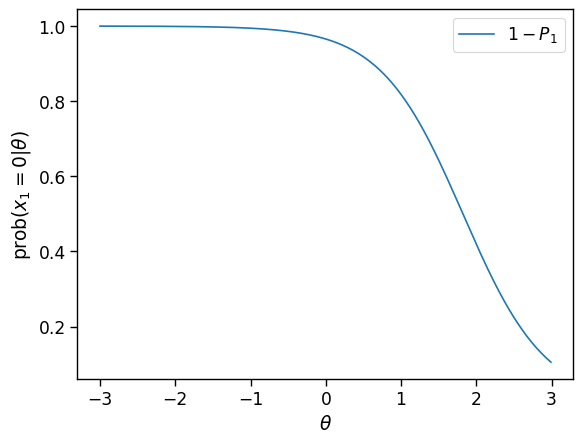

In [10]:
a1,b1,c1 = params['a_inep'].iloc[0],params['b_inep'].iloc[0],0 # os parâmetros do primeiro item
ax = sns.lineplot(x=theta,y=1-P(theta,a1,b1,c1), label=f"$1-P_{1}$");
ax.set_xlabel(r"$\theta$");ax.set_ylabel(r"$\mathrm{prob}(x_1=0|\theta)$");

Não dá, ainda, para dizer muito sobre a provável habilidade. No método de "máxima verossimilhança" (ML, da sigla em inglês), com somente a informação sobre o erro na primeira questão, a única coisa para dizer é que é mais provável que a habilidade é baixa. Veremos abaixo que no método Bayesiano, que leva em conta mais informação do que somente os acertos às questões, poderíamos dizer um pouco mais. Vamos à próxima questão, era um acerto: $x_2 =1$. Agora a probabilidade desta padrão de resposta é

$$\text{prob}(x_1 = 0, x_2 = 0|\theta) = (1-P_1(\theta))(P_2(\theta))$$

e podemos novamente fazer um gráfico da probabilidade desta "padrão de resposta" de agora duas respostas:

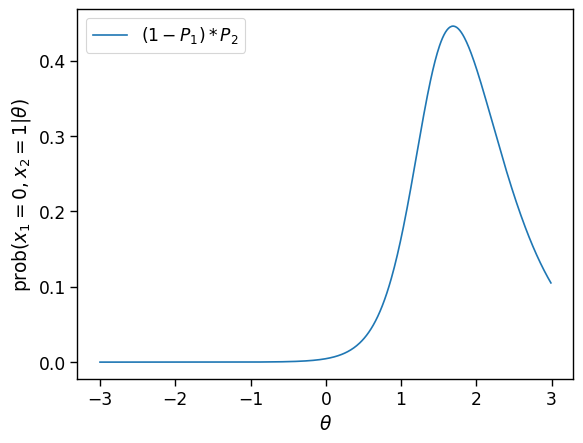

In [11]:
a2,b2,c2 = params['a_inep'].iloc[1],params['b_inep'].iloc[1],0 # os parâmetros do segundo item
ax = sns.lineplot(x=theta,y=(1-P(theta,a1,b1,c1))*P(theta,a2,b2,c2), label=f"$(1-P_{1})*P_2$");
ax.set_xlabel(r"$\theta$");ax.set_ylabel(r"$\mathrm{prob}(x_1=0,x_2=1|\theta$)");

Vemos que com duas repostas, um erro e outro acerto, já podemos fazer inferências com um pouco mais de confiança. O método de máxima verossimilhança agora estima uma habilidade próximo de 2. Vamos, para finalizar o exemplo, analisar o padrão de resposta $\{0,1,1,0\}$. 

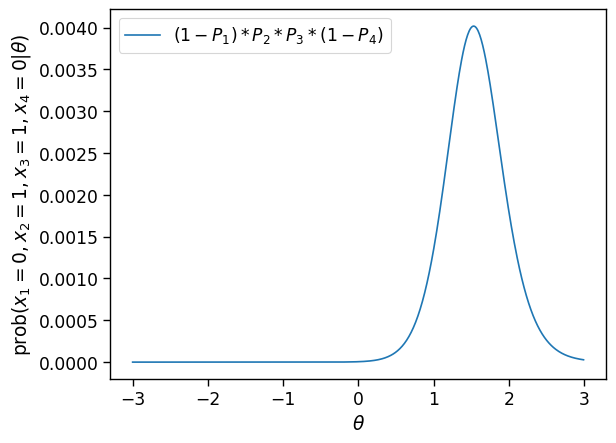

In [12]:
a3,b3,c3 = params['a_inep'].iloc[2],params['b_inep'].iloc[2],0 # os parâmetros do terceiro item
a4,b4,c4 = params['a_inep'].iloc[3],params['b_inep'].iloc[3],0 # os parâmetros do quarto item

ax = sns.lineplot(x=theta,y=(1-P(theta,a1,b1,c1))*P(theta,a2,b2,c2)*P(theta,a3,b3,c3)*(1-P(theta,a4,b4,c4)), label=f"$(1-P_{1})*P_2*P_3*(1-P_4)$");
ax.set_xlabel(r"$\theta$");ax.set_ylabel(r"$\mathrm{prob}(x_1=0,x_2=1,x_3=1,x_4=0|\theta$)");

Vemos que na medida que temos mais informação (respostas aos itens), podemos estimar a habilidade $\theta$ para qual a probabilidade de obter esta padrão é máxima fica cada vez mais estreita, correspondendo a uma incerteza na estimativa menor. 

Finalmente, veja um vídeo com uma animação como a probabilidade do padrão de acerto evolua analisamos os acertos e erros um por um de alguém que em total acertou 30 dos 45 questões. O ponto principal a observar é que mesmo após 45 questões, a largura do pico de probabilidade é considerável. Não podemos distinguir a habilidade com a de um outro candidato com um padrão de resposta levando a uma uma habilidade próxima suficiente (no caso do vídeo, da ordem de 0.2 desvios padrão, ou 20 pontos na escala ENEM). Isto é uma consequência inerente e inevitável da limitação ao número de questões que podemos usar num único exame.

<video src="_static/tri30.mp4" controls autoplay loop="false" width="800"></video>

## Estimar $\theta$ por métodos Bayesianos
Uma das desvantagens do método de inferência ML explicado acima é que para candidatos com muito poucos ou muitos acertos as estimativas de $\theta$ ficam instáveis. O ENEM usa um método de estimação da nota chamado "Expected a Posteriori" (EAP), que usa o teorema de Bayes para inverter o modelo para a probabilidade das padrões e a habilidade $\theta$:

$$ \text{prob}(\theta|\vec{x}) = \frac{\text{prob}(\vec{x}|\theta)\text{prob}(\theta)}{\text{prob}{(\vec{x})}} $$

Na prática, o termo $\text{prob}{(\vec{x})}$ é só um fator de normalização para que o posterior $\text{prob}(\theta|\vec{x})$ é uma probabilidade. O que importa na expressão acima é a multiplicação pelo "prior" $\text{prob}(\theta)$, uma premissa sobre como as habilidades são distribuídas na população. Multiplicando o prior com a modelo $\text{prob}(\vec{x}|\theta)$ resulta no posterior que pode ser interpretado como a distribuição da probabilidade de um certo $\theta$, dado a evidência: o padrão de respostas $\vec{x}$.

Tendo o posterior para $\theta$, podemos resumir o resultado de várias formas. A estimativa EAP é o valor esperado do $\theta$

$$ \theta_{\text{EAP}} = \int \theta \text{prob}(\theta|\vec{x}) d\theta $$

e uma estimativa para sua incerteza é o desvio padrão do posterior. 

No cálculo da nota do ENEM o prior é uma normal com desvio padrão 1. Calcular o posterior é surpreendemente simples na prática. É somente usar o cálculo da verossimilhança que fizeram acima, multiplacado pela função gaussiana $N(0,1)$. O resultado não é normalizado (não é uma probabilidade), mas para fins de cálculo do valor esperado podemos simplesmente usar a posterior não-normalizada como peso.

Vamos usar um determinado padrão de respostas e tentar reproduzir a nota que o INEP forneceu, com os parâmetros das questões, também fornecidos pelo INEP. 

In [13]:
def displaypadr(df):
    info = df.iloc[:,-3:]
    df = df.iloc[:,:-3]
    checkmap = {1: '✔',0: '✖'}  
    df = df.map(lambda x: checkmap[x])
    if len(df) == 1:
        return "".join(list(df.values[0])) + f"\n acertos {info.iloc[0,0]}, nota inep {info.iloc[0,2]}"
    return df


In [14]:
ano = 2023
area = 'MT'
padr = load_acertos(ano,area,1)
print(f"Um candidato de {ano}, {area}:\n",displaypadr(padr),'\n')
params = params_inep(ano,area) # os parâmetros TRI fornecidos pelo INEP
print("Os primeiros cinco parâmetros das questões:")
params[:5]

Um candidato de 2023, MT:
 ✖✖✖✔✖✖✔✔✖✖✖✖✖✖✖✔✖✖✖✖✔✖✖✔✖✔✖✔✖✖✖✖✖✖✖✖✖✖✔✖✖✔✖
 acertos 10, nota inep 435.3 

Os primeiros cinco parâmetros das questões:


,a_inep,b_inep,c_inep,u
CO_ITEM,,,,
81742,1.63418,1.34475,0.13956,1
28932,2.39434,1.98395,0.11508,1
37441,3.01304,2.67185,0.08455,1
86783,3.58609,3.00088,0.19242,1
14410,2.38237,1.88674,0.10321,1


A conta para reproduzir a nota a partir destas informações não é complexo. Abre a célula abaixo se quiser ver os detalhes. Calculamos o array `lh`("likelihood"), de $\theta = $ -3 até 3, multiplando 45 vezes pelo $P_i(a_i,b_i,c_i;\theta)$ ou $1-P_i(a_i,b_i,c_i;\theta)$, conforme se o candidato acertou ou errou, respectivamente. Depois de ter a curva `lh`, a nota é simplesmente o valor onde este é um máximo (`lh.argmax()`). Se usar o método EAP (Bayesiano), multiplica pelo a priori, uma curva normal no nosso caso, e calculo o valor esperado de $\theta$. Nenhum bixo de sete cabeças, abrimos a caixa opaca da nota ENEM calculado pelo TRI!

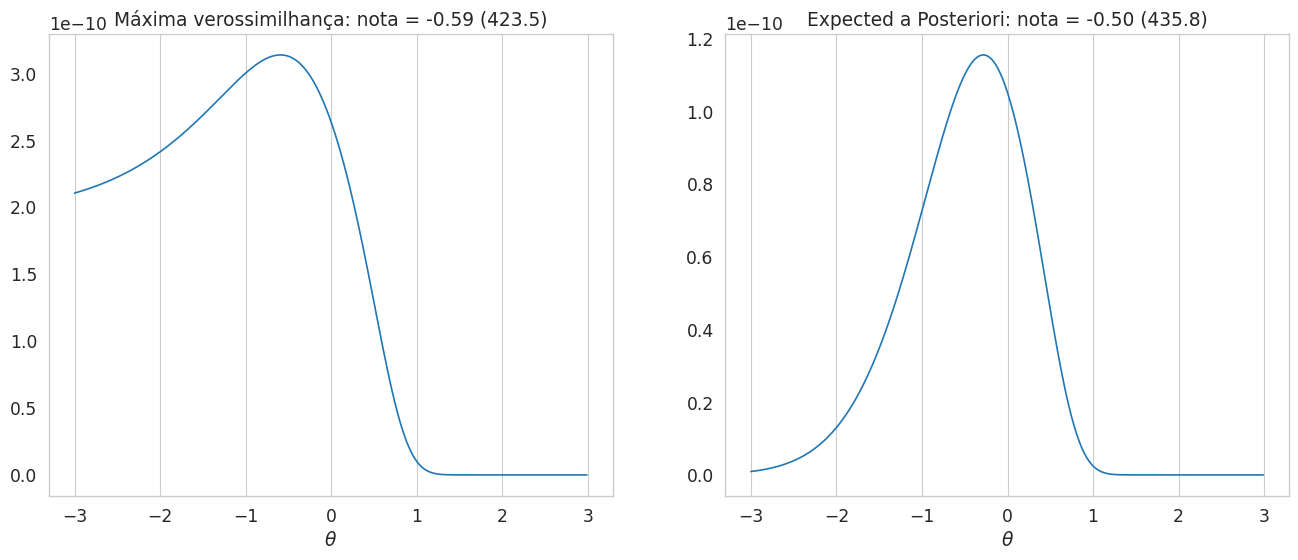

In [26]:
params = params.join(padr.reset_index().T).rename(columns={0:'acertou'})
theta = np.arange(-3,3,0.01)

def P(theta,a=1,b=0,c=0):
    'O modelo 3PL'
    return c + (1-c)*1/(1+np.exp(a*(b-theta)))


lh = np.ones(len(theta))
for item,value in params.iterrows():    
    acertou = int(value.iloc[-1])
    if acertou:
        lh = lh*P(theta,a=value['a_inep'],b=value['b_inep'],c=value['c_inep'])
    else:
        lh = lh*(1-P(theta,a=value['a_inep'],b=value['b_inep'],c=value['c_inep']))

    nota_ml = (-3+lh.argmax()*0.01)
    posterior = lh*norm.pdf(theta)
    nota_eap = np.average(theta, weights=posterior)



with sns.axes_style("whitegrid"):
        fig,axs = plt.subplots(1,2,sharex=True,figsize = (16,6))
        ax1 = axs[0]; ax2 = axs[1]
        sns.lineplot(x=theta,y=lh,ax=ax1);
        ax1.set_xlabel(r"$\theta$");ax.set_ylabel(r"$\mathrm{prob}(\vec{x_i}|\theta)$");
        ax1.set_title(f"Máxima verossimilhança: nota = {nota_ml:.2f} ({notas_to_enem_scale(nota_ml,area):.1f})");
        ax1.grid(axis='y')
        sns.lineplot(x=theta,y=posterior,ax=ax2);
        ax2.set_xlabel(r"$\theta$");ax.set_ylabel(r"Posterior");
        ax2.set_title(f"Expected a Posteriori: nota = {nota_eap:.2f} ({notas_to_enem_scale(nota_eap,area):.1f})");
        ax2.grid(axis='y')


Vemos que o método EAP "encolhe" as notas um pouco para a média (0 na escala TRI, 500 na escala ENEM). Este efeito é maior para notas altas (acima de 2 desvios padrão ou 700) e notas baixas. 

## Curiosidades
Agora que sabemos calcular notas ENEM a partir de qualquer padrão de respostas, podemos responder algumas perguntas. 

### Notas máximas e mínimas
Por exemplo, o que seria a nota máxima ou mínima possível? É fácil de ver que se usar o método de máxima verossimilhança (gráfica da esquerda acima), não vamos conseguir uma estimativa para padrões $\{0,0,0\ldots\}$ (errou tudo) ou $\{1,1,1\ldots\}$ (acertou tudo). A razão é que uma multiplicação (45 vezes) de uma curva $P(\theta)$ do tipo que temos usado, só vai ter um máximo ou mínimo em $\theta = \pm \infty$. 

Mas para o método EAP, multiplicamos estas curvas pela Gaussiana $\N(0,1)$ e isso vai levar a um $\theta_\text{EAP}$ finito, que vai depender dos parâmetros $a_i,b_i,c_i$, que são diferentes para cada ano e area. Vamos calcular as notas máximas e mínimas:

In [63]:
l=[]
for ano in range(2019,2024):
    for area in ['MT','CN','CH']:
        itens = params_inep(ano,area).index
        padrmin = pd.DataFrame(np.zeros((1,len(itens))),columns = itens,index=[0])
        padrmax = pd.DataFrame(np.ones((1,len(itens))),columns = itens,index=[0])
        notamax = score_inep(padrmax,ano,area,enemscale=True).iloc[0,0]
        notamin = score_inep(padrmin,ano,area,enemscale=True).iloc[0,0]
        l.append([ano,area,notamax,notamin])
df = pd.DataFrame(l,columns = ['ano','area','notamax','notamin'])
df

,ano,area,notamax,notamin
0,2019,MT,1009.610283,358.818257
1,2019,CN,866.609674,327.755286
2,2019,CH,837.714870,315.774476
3,2020,MT,995.065465,326.976060
4,2020,CN,864.530783,332.537772
5,2020,CH,868.646012,328.287146
6,2021,MT,966.255031,353.788416
7,2021,CN,873.558846,339.644722
8,2021,CH,850.506098,328.792706
9,2022,MT,1025.001122,336.741927


### Respostas aleatórias
Finalmente, mostramos a distribuição das notas para candidatos que respondem aleatoriamente. O histograma na esquerda simula o que acontece para escolhas aleatórias mesmo (há 5 alternativas nas provas do ENEM). O histograma da direita mostra o resultado para candidatos que para cada questão conseguem eliminar 3 alternativas erradas e escolhem ao acaso entre as duas outras alternativas. 

(Há uma grande chance que alguns destes últimos candidatos seriam admitidos em cursos bastante seletivos, com notas de corte maior que 700 pontos) 

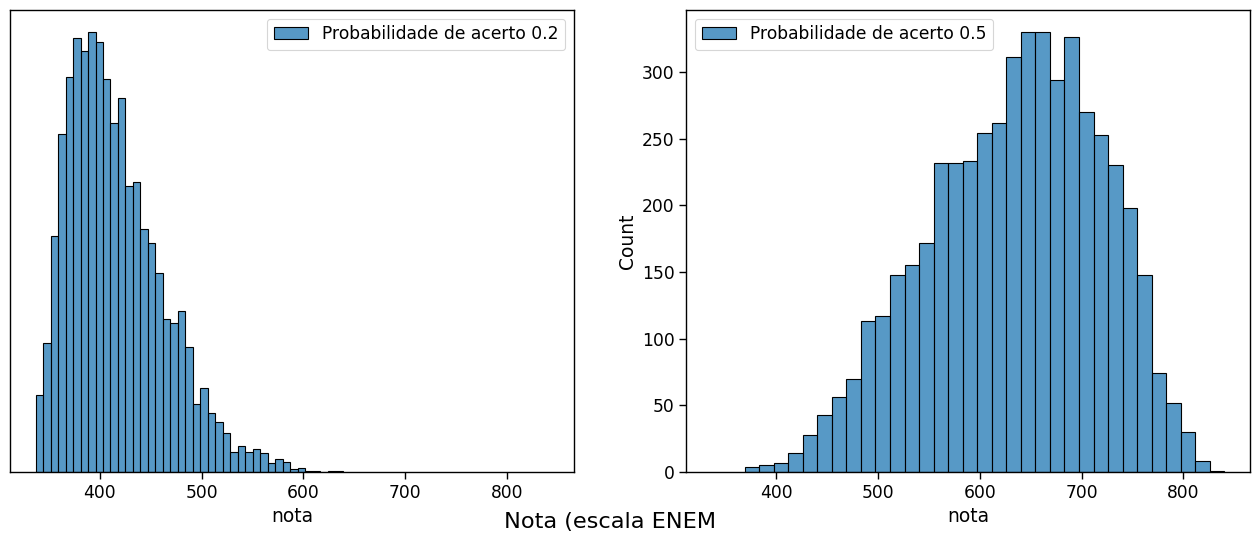

In [64]:
def padr_random(prova,p=0.2,N=1):
    itens = item_info_inep(prova=prova).query("IN_ITEM_ABAN == 0")['CO_ITEM']
    cols = itens.astype(int).sort_values().values
    padr = np.random.default_rng().random(size=(N,len(itens))) < p
    #padr = np.random.randint(0,2,size=(N,len(itens)))
    df = pd.DataFrame(padr,columns = cols)
    return df.astype(int)
    
fig,axs = plt.subplots(1,2,sharex=True,figsize = (16,6))
ax1 = axs[0]; ax2 = axs[1]
padr = padr_random(1075,.2,5000)
scores = score_inep(padr,2022,'MT',enemscale=True)
sns.histplot(scores,x='nota',ax=ax1,label='Probabilidade de acerto 0.2')
ax1.legend()
padr = padr_random(1075,.5,5000)
scores = score_inep(padr,2022,'MT',enemscale=True)
sns.histplot(scores,x='nota',ax=ax2,label='Probabilidade de acerto 0.5')
ax1.set_ylabel("")
ax1.set_yticks([])
ax1.legend()
ax2.legend()
fig.supxlabel("Nota (escala ENEM)");